In [25]:
#Assignment 4

#Step 1: Load data and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Survival analysis
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test

#Cox regression
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

#Random Survival Forests
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


df = pd.read_csv("../Data/RADCURE_Clinical_v04_20241219.csv")
df.head()

,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,...,NaN,NaN,NaN,NaN,NaN,NaN,S (suspicious),2008-05-27,0,0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


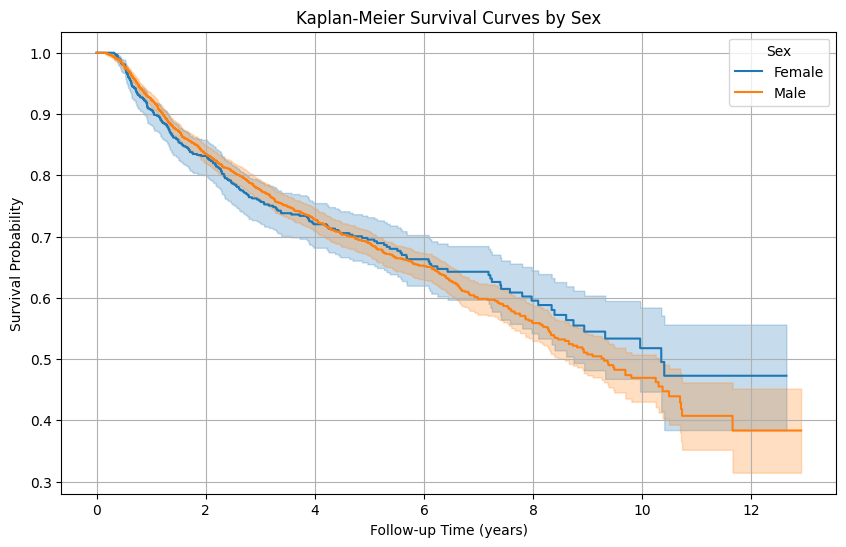

Log-Rank Test p-value: 0.67291022863651


In [ ]:
#Step 2 Kaplan-Meier curves

#Kaplan-Meier Curves: By Sex

#Clean and prepare data
df_km = df[["Length FU", "Status", "Sex"]].copy()
df_km = df_km.dropna()

#Convert Status to binary --> 1 = dead, 0 = alive
df_km["event"] = df_km["Status"].str.lower().map({"dead": 1, "alive": 0})

kmf = KaplanMeierFitter()

#Plot
plt.figure(figsize=(10, 6))
for group in df_km["Sex"].unique():
    mask = df_km["Sex"] == group
    kmf.fit(df_km[mask]["Length FU"], df_km[mask]["event"], label=str(group))
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves by Sex")
plt.xlabel("Follow-up Time (years)")
plt.ylabel("Survival Probability")
plt.legend(title="Sex")
plt.grid(True)
plt.show()

#Split the data by Sex
group1 = df_km[df_km["Sex"] == "Male"]
group2 = df_km[df_km["Sex"] == "Female"]

#Perform log-rank test
results = logrank_test(
    durations_A=group1["Length FU"], event_observed_A=group1["event"],
    durations_B=group2["Length FU"], event_observed_B=group2["event"])
print("Log-Rank Test p-value:", results.p_value)

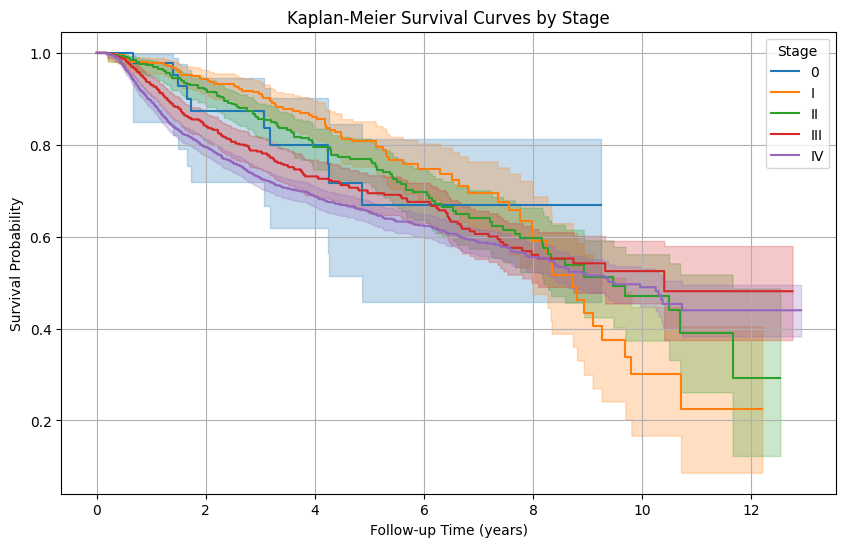

Log-Rank Test p-value: 2.341462177592083e-05


In [ ]:
#Step 2 Kaplan-Meier curves continued

#Kaplan-Meier Curves: By Stage

#For simplicity, we will group detailed stages into broader categories. 
df["Stage"].unique()
stage_map = {
    '0': '0', 
    'I': 'I', 'IA': 'I', 'IB': 'I',
    'II': 'II', 'IIA': 'II', 'IIB': 'II',
    'III': 'III', 'IIIA': 'III', 'IIIB': 'III', 'IIIC': 'III',
    'IV': 'IV', 'IVA': 'IV', 'IVB': 'IV', 'IVC': 'IV'}

df_km2 = df[["Length FU", "Status", "Stage"]].copy()
df_km2["Stage"] = df_km2["Stage"].map(stage_map)
df_km2 = df_km2.dropna()

#Convert Status to binary --> 1 = dead, 0 = alive 
df_km2["event"] = df_km2["Status"].str.lower().map({"dead": 1, "alive": 0})

#Remove NA
df_km2 = df_km2[df_km2["Stage"].notna()]

#Plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for group in sorted(df_km2["Stage"].unique()):
    mask = df_km2["Stage"] == group
    kmf.fit(df_km2[mask]["Length FU"], df_km2[mask]["event"], label=group)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves by Stage")
plt.xlabel("Follow-up Time (years)")
plt.ylabel("Survival Probability")
plt.legend(title="Stage")
plt.grid(True)
plt.show()

#Perform log-rank test
results = multivariate_logrank_test(df_km2["Length FU"], df_km2["Stage"], df_km2["event"])
print("Log-Rank Test p-value:", results.p_value)



In [16]:
#Step 3 Cox Regression

#Select + clean data
df_cox = df[["Length FU", "Status", "Age", "Sex", "Stage"]].copy()
df_cox = df_cox.dropna()

#Convert Status to binary --> 1 = dead, 0 = alive 
df_cox["event"] = df_cox["Status"].str.lower().map({"dead": 1, "alive": 0})

#For simplicity, we will group detailed stages into broader categories. 
stage_map = {
    '0': '0', 
    'I': 'I', 'IA': 'I', 'IB': 'I',
    'II': 'II', 'IIA': 'II', 'IIB': 'II',
    'III': 'III', 'IIIA': 'III', 'IIIB': 'III', 'IIIC': 'III',
    'IV': 'IV', 'IVA': 'IV', 'IVB': 'IV', 'IVC': 'IV'}
df_cox["Stage"] = df_cox["Stage"].map(stage_map)

#Drop NA
df_cox = df_cox.dropna()

#One-hot encode categorical variables
df_cox = pd.get_dummies(df_cox, columns=["Sex", "Stage"], drop_first=True)

#Define columns
columns_for_model = [col for col in df_cox.columns if col not in ["Status"]]

#Fit model
cph = CoxPHFitter()
cph.fit(df_cox[columns_for_model], duration_col="Length FU", event_col="event")
print(cph.summary)



               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
Age        0.050245   1.051529  0.002981        0.044403        0.056087   
Sex_Male   0.042292   1.043199  0.077748       -0.110090        0.194674   
Stage_I   -0.215880   0.805832  0.335913       -0.874258        0.442497   
Stage_II   0.040555   1.041389  0.330168       -0.606563        0.687673   
Stage_III  0.319106   1.375897  0.324843       -0.317575        0.955787   
Stage_IV   0.618536   1.856209  0.319211       -0.007105        1.244177   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z  \
covariate                                                                
Age                   1.045403             1.057690     0.0  16.856062   
Sex_Male              0.895753             1.214915     0.0   0.543966   
Stage_I               0.417172             1.556590     0.0  -0.642667   
Stage_II             

In [17]:
#Step 3 continued

#Check proportional hazards assumption with Schoenfeld residuals test
results = proportional_hazard_test(cph, df_cox[columns_for_model], time_transform="rank")
print(results.summary)

           test_statistic         p  -log2(p)
Age              7.103629  0.007693  7.022275
Sex_Male         3.262148  0.070896  3.818148
Stage_I          0.224497  0.635635  0.653730
Stage_II         0.000034  0.995343  0.006734
Stage_III        1.417566  0.233804  2.096626
Stage_IV         3.277495  0.070236  3.831644


RSF Concordance Index: 0.6168519161745977


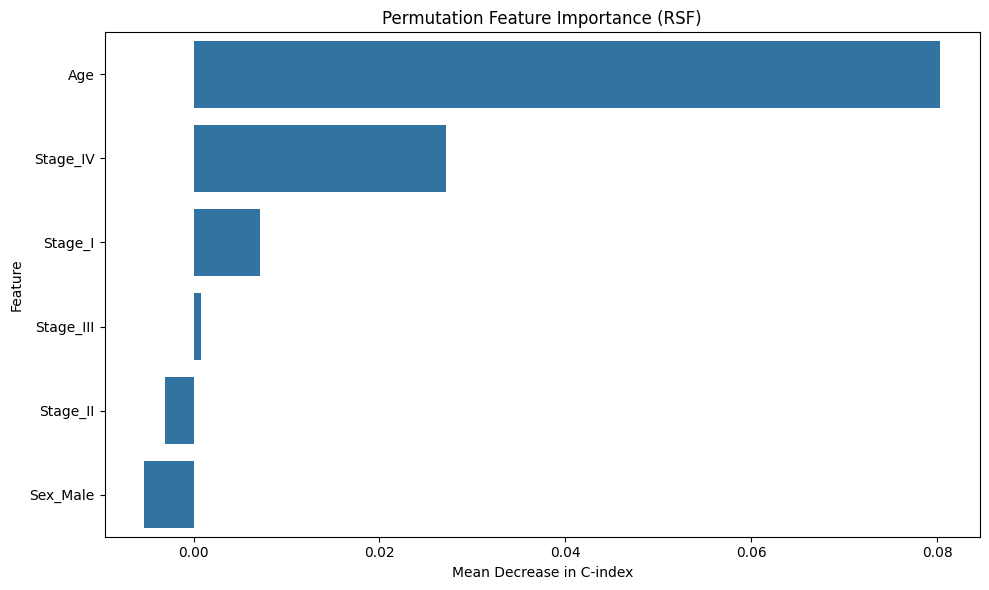

In [32]:
#Step 4 Random Survival Forests (RSF)

#Prepare data in sksurv format
df_rsf = df[["Length FU", "Status", "Age", "Sex", "Stage"]].copy()
df_rsf = df_rsf.dropna()
df_rsf["event"] = df_rsf["Status"].str.lower().map({"dead": True, "alive": False})

#Simplified stages 
stage_map = {
    '0': '0',
    'I': 'I', 'IA': 'I', 'IB': 'I',
    'II': 'II', 'IIA': 'II', 'IIB': 'II',
    'III': 'III', 'IIIA': 'III', 'IIIB': 'III', 'IIIC': 'III',
    'IV': 'IV', 'IVA': 'IV', 'IVB': 'IV', 'IVC': 'IV'}
df_rsf["Stage"] = df_rsf["Stage"].map(stage_map)

#Drop NAs
df_rsf = df_rsf.dropna()

#One-hot encode categorical variables
df_rsf_encoded = pd.get_dummies(df_rsf.drop(columns=["Status"]), drop_first=True)

#Create structured array for survival
y_rsf = Surv.from_dataframe("event", "Length FU", df_rsf_encoded)

#Drop survival columns from predictors
X_rsf = df_rsf_encoded.drop(columns=["event", "Length FU"])

#Split data
X_train, X_test, y_train, y_test = train_test_split(X_rsf, y_rsf, test_size=0.2, random_state=42)

#Fit RSF model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=42)
rsf.fit(X_train, y_train)

#Calculate Concordance Index
c_index_rsf = concordance_index_censored(y_test["event"], y_test["Length FU"], rsf.predict(X_test))[0]
print("RSF Concordance Index:", c_index_rsf)

#Use permutation importance to estimate feature contributions

def rsf_score(estimator, X, y):
    return concordance_index_censored(y["event"], y["Length FU"], estimator.predict(X))[0]

perm_result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42, scoring=rsf_score)

#Create a df for plotting
perm_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_result.importances_mean
}).sort_values(by="Importance", ascending=False)

#Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=perm_importance_df, x="Importance", y="Feature")
plt.title("Permutation Feature Importance (RSF)")
plt.xlabel("Mean Decrease in C-index")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
#Step 4 continued

#Calculate C-Index for cox model for comparison 

#Prepare y_true in structured array format for sksurv
y_cox = Surv.from_dataframe("event", "Length FU", df_cox)

#Predict risk scores (higher score = higher risk)
cox_risk_scores = cph.predict_partial_hazard(df_cox)

#Calculate C-index
c_index_cox = concordance_index_censored(
    y_cox["event"], y_cox["Length FU"], -cox_risk_scores)[0]

print("Cox Model Concordance Index:", c_index_cox)


Cox Model Concordance Index: 0.3451133526354564
